In [1]:
!pip install stanza

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 73.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 40.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12

In [2]:
!pip install nltk

In [3]:
import nltk
from nltk.corpus import stopwords

import numpy as np
import os
import pandas as pd
import stanza
import torch
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from torch.utils.data import Dataset
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    EarlyStoppingCallback,
    Trainer,
    TrainingArguments
)
from wordcloud import WordCloud

# (manually) filtered ELIta
elita_df = pd.read_csv("ELIta_filtered.csv")
# converting ELIta into a dictionary for quick lookup
elita_dict = {row["Parola"]: row.iloc[1:].to_dict() for _, row in elita_df.iterrows()}

In [4]:
# loading Stanza for tokenization & lemmatization
stanza.download("it")
nlp = stanza.Pipeline("it", processors="tokenize,lemma,pos", use_gpu=True)

# ELIta lexicon
elita_df = pd.read_csv("ELIta_filtered.csv")
elita_dict = {row["Parola"]: row.iloc[1:].to_dict() for _, row in elita_df.iterrows()}

INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Downloading default packages for language: it (Italian) ...


INFO:stanza:Downloaded file to /root/stanza_resources/it/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: it (Italian):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| mwt       | combined          |
| pos       | combined_charlm   |
| lemma     | combined_nocharlm |

INFO:stanza:Using device: cuda
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Done loading processors!


In [6]:
def compute_emotion_scores(text):
  """
    This function alculates average emotion scores for a given text using the ELIta lexicon.

    Parameters:
        text (str): the input text to analyze.

    Returns:
        dict: a dictionary of average emotion scores. Each key is an emotion label,
              and each value is the average score. Returns 0 for each emotion if no words match.
    """
  doc = nlp(text)
  words = [word.lemma for sentence in doc.sentences for word in sentence.words]

  scores = {key: [] for key in elita_dict[next(iter(elita_dict))].keys()}
  matched_words = 0  # track how many words match ELIta

  for word in words:
      if word in elita_dict:
          matched_words += 1
          for emotion, score in elita_dict[word].items():
              scores[emotion].append(score)

  # handle cases where few words match ELIta
  if matched_words == 0:
      print(f"Warning: No words matched ELIta in this transcript.")

  avg_scores = {emotion: np.mean(scores[emotion]) if scores[emotion] else 0 for emotion in scores}

  return avg_scores

In [7]:
# load manually labeled transcripts
df = pd.read_csv("trans_labeled.csv")

# computing emotion features for all texts
df_emotions = df["text"].apply(compute_emotion_scores).apply(pd.Series)

# keep filenames & labels
df_final = pd.concat([df[["filename", "label"]], df_emotions], axis=1)
df_final = df_final.round(4)
df_final.to_csv("features.csv", index=False, encoding="utf-8")
print(f"Emotion features extracted. Saved as 'features.csv'.")

Emotion features extracted. Saved as 'features.csv'.


This step below analyzes whether emotional language differs between depressed and non-depressed individuals. Emotion scores were extracted from transcripts using the ELIta lexicon. The results indicate that depressed individuals tend to express slightly higher levels of sadness and fear, and slightly lower levels of joy and trust compared to non-depressed individuals. However, these differences are subtle, suggesting that emotional features alone may not provide a strong basis for distinguishing between the two groups. This highlights the importance of exploring cognitive linguistic markers, such as pronoun usage, negations, and sentence complexity, to assess whether they offer clearer distinctions. The next step involves extracting and evaluating these linguistic features to better understand their role in identifying depression.

In [8]:
# load extracted emotion features file
df = pd.read_csv("features.csv")
df_numeric = df.drop(columns=["filename"])

# group by depression label and compute mean emotion scores
grouped = df_numeric.groupby("label").mean()

print("Average Emotion Scores by Class:")
grouped.head()

Average Emotion Scores by Class:


,gioia,tristezza,rabbia,disgusto,paura,fiducia,sorpresa,aspettativa
label,,,,,,,,
0,0.389919,0.119417,0.075687,0.029763,0.150437,0.314829,0.214238,0.449773
1,0.323368,0.144768,0.095824,0.031484,0.168006,0.277057,0.176387,0.403843


In [14]:
def compute_linguistic_features(text):
  """
    Dinamically extracting cognitive linguistic features from a given text using a Stanza NLP pipeline.

    This function analyzes pronoun use, verb tense, negations, and sentence structure
    to identify patterns associated with psychological states such as depression.

    Parameters:
        text (str): The input text to analyze.

    Returns:
        dict: A dictionary containing counts and normalized values for:
              - First-person pronouns and verbs
              - Negations
              - Past and present tense verbs
              - Average sentence length
              - Total word and sentence counts
              - Feature values normalized per sentence
  """
  doc = nlp(text)
  pronoun_count = 0
  first_person_verbs = 0
  negation_count = 0
  past_tense_count = 0
  present_tense_count = 0
  total_words = 0
  total_sentences = len(doc.sentences)
  for sentence in doc.sentences:
      for word in sentence.words:
          lemma = word.lemma.lower()
          total_words += 1

          # detect first-person
          if word.upos == "PRON" and "Person=1" in (word.feats or ""):
              pronoun_count += 1

          # detect first-person singular verbs
          if word.upos == "VERB" and "Person=1" in (word.feats or "") and "Number=Sing" in (word.feats or ""):
              first_person_verbs += 1

          # detect negations
          if word.lemma in {"non", "mai", "nessuno", "niente", "nemmeno", "neanche", "senza"}:
              negation_count += 1

          # detect verb tense
          if word.upos == "VERB" and word.feats:
              if "Tense=Past" in word.feats:
                  past_tense_count += 1
              elif "Tense=Pres" in word.feats:
                  present_tense_count += 1

  # average sentence length
  avg_sentence_length = total_words / total_sentences if total_sentences > 0 else 0

  first_person_total = pronoun_count + first_person_verbs                     # include verbs in first-person count
  first_person_per_sentence = first_person_total / total_sentences if total_sentences > 0 else 0
  negation_per_sentence = negation_count / total_sentences if total_sentences > 0 else 0
  past_tense_per_sentence = past_tense_count / total_sentences if total_sentences > 0 else 0
  present_tense_per_sentence = present_tense_count / total_sentences if total_sentences > 0 else 0

  return {
      "first_person_pronouns": pronoun_count,
      "first_person_verbs": first_person_verbs,
      "first_person_total": first_person_total,
      "negations": negation_count,
      "past_tense_verbs": past_tense_count,
      "present_tense_verbs": present_tense_count,
      "avg_sentence_length": avg_sentence_length,
      "total_words": total_words,
      "total_sentences": total_sentences,
      "first_person_per_sentence": first_person_per_sentence,
      "negation_per_sentence": negation_per_sentence,
      "past_tense_per_sentence": past_tense_per_sentence,
      "present_tense_per_sentence": present_tense_per_sentence
  }

In [13]:
df = pd.read_csv("trans_labeled.csv")

# computing linguistic features for all texts
df_linguistic = df["text"].apply(compute_linguistic_features).apply(pd.Series)
df_final = pd.concat([df[["filename", "label"]], df_linguistic], axis=1)
df_final = df_final.round(4)
df_final.to_csv("linguistic_features.csv", index=False, encoding="utf-8")
print(f"Saved as 'linguistic_features.csv'.")

Saved as 'linguistic_features.csv'.


In [15]:
df = pd.read_csv("linguistic_features.csv")
numeric_cols = df.select_dtypes(include=np.number).columns
df_numeric = df[numeric_cols]
summary_stats = df_numeric.groupby("label").mean().round(4)
print("Average Linguistic Features by Class:")
summary_stats.head()

Average Linguistic Features by Class:


,first_person_pronouns,first_person_verbs,first_person_total,negations,past_tense_verbs,present_tense_verbs,avg_sentence_length,total_words,total_sentences,first_person_per_sentence,negation_per_sentence,past_tense_per_sentence,present_tense_per_sentence
label,,,,,,,,,,,,,
0,8.8462,9.0000,17.8462,5.3077,11.9423,20.1731,22.6248,403.1923,18.1538,0.9963,0.3002,0.6631,1.1218
1,12.2540,12.7619,25.0159,8.2857,11.2381,24.0317,22.7685,381.9841,20.5397,1.4818,0.4626,0.7100,1.4113


# **Baseline**

This study examined the extent to which emotional and cognitive language features distinguish depressed individuals in Italian transcriptions. Linguistic markers such as first person pronouns and verbs (indicating self focus), negations (reflecting negative framing), and verb tense usage (suggesting past oriented rumination or present distress) were analyzed alongside emotion related features such as sadness (tristezza) and anger (rabbia), to uncover patterns associated with depression. The analysis revealed that depressed individuals exhibit a significantly higher degree of self referential language, reinforcing findings from previous studies conducted in English. Among emotional indicators, sadness emerged as the strongest predictor of depression, while negations and first person usage also played a central role in differentiating between groups. Depressed individuals demonstrated a blend of past and present tense focus, pointing to both rumination and immediate distress as key linguistic markers. Using these features, predictive models were trained, with Support Vector Machines outperforming Logistic Regression and achieving 86.8% accuracy in cross validation. These results support the idea that emotional and cognitive language signals are reliable indicators of depression in Italian and contribute to the broader cross linguistic understanding of how depression is reflected in language.

In [16]:
linguistic_df = pd.read_csv("linguistic_features.csv")
emotion_df = pd.read_csv("features.csv")
df_final = pd.merge(linguistic_df, emotion_df.drop(columns=["label"]), on="filename")
df_final.to_csv("features_final.csv", index=False, encoding="utf-8")
print(f"Merged dataset saved as 'features_final.csv'.")
df_final.head()

Merged dataset saved as 'features_final.csv'.


,filename,label,first_person_pronouns,first_person_verbs,first_person_total,negations,past_tense_verbs,present_tense_verbs,avg_sentence_length,total_words,...,past_tense_per_sentence,present_tense_per_sentence,gioia,tristezza,rabbia,disgusto,paura,fiducia,sorpresa,aspettativa
0,03_PF66_3.txt,1,61.0,40.0,101.0,12.0,34.0,65.0,16.8852,1030.0,...,0.5574,1.0656,0.3497,0.0951,0.0643,0.0249,0.1430,0.2500,0.1667,0.3930
1,32_PF51_2.txt,1,3.0,6.0,9.0,2.0,5.0,6.0,19.1429,134.0,...,0.7143,0.8571,0.4113,0.1492,0.1008,0.0403,0.2056,0.2339,0.2218,0.3871
2,17_PF44_2.txt,1,5.0,3.0,8.0,2.0,13.0,11.0,14.1053,268.0,...,0.6842,0.5789,0.3995,0.1005,0.0686,0.0147,0.1324,0.3113,0.2574,0.4338
3,20_PM43_2.txt,1,1.0,1.0,2.0,3.0,2.0,6.0,20.0000,160.0,...,0.2500,0.7500,0.2862,0.1920,0.1341,0.0906,0.1413,0.2572,0.1413,0.3152
4,52_PM53_4.txt,1,17.0,24.0,41.0,9.0,5.0,42.0,15.8261,364.0,...,0.2174,1.8261,0.3462,0.1451,0.0839,0.0210,0.1486,0.2727,0.1906,0.4248


In [17]:
transcriptions_df = pd.read_csv("trans_labeled.csv")
features_df = pd.read_csv("features_final.csv")
df_merged = pd.merge(transcriptions_df, features_df.drop(columns=["label"]), on="filename")
df_merged.to_csv("final_dataset.csv", index=False, encoding="utf-8")
print(f"Merged dataset saved as 'final_dataset.csv'.")
df_merged.head()

Merged dataset saved as 'final_dataset.csv'.


,filename,text,label,first_person_pronouns,first_person_verbs,first_person_total,negations,past_tense_verbs,present_tense_verbs,avg_sentence_length,...,past_tense_per_sentence,present_tense_per_sentence,gioia,tristezza,rabbia,disgusto,paura,fiducia,sorpresa,aspettativa
0,03_PF66_3.txt,quest'ultima settimana l'ho trascorsa un poco ...,1,61.0,40.0,101.0,12.0,34.0,65.0,16.8852,...,0.5574,1.0656,0.3497,0.0951,0.0643,0.0249,0.1430,0.2500,0.1667,0.3930
1,32_PF51_2.txt,"abbastanza bene, non ci sono state grosse novi...",1,3.0,6.0,9.0,2.0,5.0,6.0,19.1429,...,0.7143,0.8571,0.4113,0.1492,0.1008,0.0403,0.2056,0.2339,0.2218,0.3871
2,17_PF44_2.txt,quest'ultima settimana l'ho trascorsa con dell...,1,5.0,3.0,8.0,2.0,13.0,11.0,14.1053,...,0.6842,0.5789,0.3995,0.1005,0.0686,0.0147,0.1324,0.3113,0.2574,0.4338
3,20_PM43_2.txt,l'ultima settimana un po' in paura perché mio ...,1,1.0,1.0,2.0,3.0,2.0,6.0,20.0000,...,0.2500,0.7500,0.2862,0.1920,0.1341,0.0906,0.1413,0.2572,0.1413,0.3152
4,52_PM53_4.txt,questa settimana l’ho trascorsa per lo più lav...,1,17.0,24.0,41.0,9.0,5.0,42.0,15.8261,...,0.2174,1.8261,0.3462,0.1451,0.0839,0.0210,0.1486,0.2727,0.1906,0.4248


In [18]:
df = pd.read_csv("features_final.csv")

selected_features = [
    "first_person_total", "negations", "past_tense_per_sentence", "present_tense_per_sentence",
    "avg_sentence_length", "gioia", "tristezza", "fiducia", "rabbia"
]

X = df[selected_features]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

# getting feature importance
importance = np.abs(model.coef_).flatten()
feature_importance_df = pd.DataFrame({"Feature": selected_features, "Importance": importance})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)
display(feature_importance_df)

,Feature,Importance
5,gioia,1.251782
4,avg_sentence_length,1.052469
3,present_tense_per_sentence,0.744978
2,past_tense_per_sentence,0.740573
6,tristezza,0.701813
0,first_person_total,0.635740
7,fiducia,0.460252
8,rabbia,0.235552
1,negations,0.063246


In [20]:
nltk.download("stopwords")
stop_words_italian = stopwords.words("italian")

# loading merged dataset (transcriptions + selected features)
df = pd.read_csv("final_dataset.csv")

# ensuring data is shuffled to avoid grouped labels
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

X_text = df["text"]

# most important features chosen
selected_features = [
    "tristezza", "first_person_total", "rabbia", "avg_sentence_length",
    "negations", "past_tense_per_sentence", "present_tense_per_sentence"
]
X_features = df[selected_features]
y = df["label"] # target label

# from text data to TF-IDF Vectors
tfidf = TfidfVectorizer(max_features=1000, stop_words=stop_words_italian)
X_text_tfidf = tfidf.fit_transform(X_text).toarray()
scaler = StandardScaler()
X_features_scaled = scaler.fit_transform(X_features)
X_final = np.hstack((X_text_tfidf, X_features_scaled))

# stratified train test split to ensure balanced class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, stratify=y, random_state=42
)

# SVM with linear kernel
svm_model = SVC(kernel="linear", C=1.0, random_state=42)
svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)

accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {accuracy_svm:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_svm))

# k-fold cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_svm = cross_val_score(svm_model, X_final, y, cv=skf, scoring="accuracy")
print(f"\nCross-Validation Accuracy Scores (SVM): {cv_scores_svm}")
print(f"Mean Accuracy (SVM): {np.mean(cv_scores_svm):.4f} ± {np.std(cv_scores_svm):.4f}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


SVM Accuracy: 0.8400
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.73      0.80        11
           1       0.81      0.93      0.87        14

    accuracy                           0.84        25
   macro avg       0.85      0.83      0.83        25
weighted avg       0.85      0.84      0.84        25


Cross-Validation Accuracy Scores (SVM): [0.88       0.83333333 0.83333333 0.83333333 0.83333333]
Mean Accuracy (SVM): 0.8427 ± 0.0187


# **Transformer**

In [23]:
df = pd.read_csv("final_dataset.csv")
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
X_text = df["text"].tolist()
y = df["label"].tolist()

# train test split stratified
X_train, X_test, y_train, y_test = train_test_split(X_text, y, test_size=0.2, stratify=y, random_state=42)
os.environ["WANDB_DISABLED"] = "true"
# bertino tokenizer
MODEL_NAME = "indigo-ai/BERTino"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_function(texts): # tokenization function
    return tokenizer(texts, padding="max_length", truncation=True, max_length=512, return_tensors="pt")

class DepressionDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenize_function(texts)
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.encodings["input_ids"][idx],
            "attention_mask": self.encodings["attention_mask"][idx],
            "labels": self.labels[idx],
        }

train_dataset = DepressionDataset(X_train, y_train)
test_dataset = DepressionDataset(X_test, y_test)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, pin_memory=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, pin_memory=True)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=2
)

# training args
training_args = TrainingArguments(
    output_dir="./results",
    run_name="bertino_depression",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=8,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    fp16=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)
model.save_pretrained("./bertino_depression_model")
tokenizer.save_pretrained("./bertino_depression_model")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at indigo-ai/BERTino and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss
1,0.673600,0.597949
2,0.576000,0.511436
3,0.469000,0.434648
4,0.417300,0.376572
5,0.272100,0.329624
6,0.234300,0.303914
7,0.198700,0.289580
8,0.193000,0.284482


Evaluation Results: {'eval_loss': 0.2844824194908142, 'eval_runtime': 0.1234, 'eval_samples_per_second': 202.558, 'eval_steps_per_second': 32.409, 'epoch': 8.0}


('./bertino_depression_model/tokenizer_config.json',
 './bertino_depression_model/special_tokens_map.json',
 './bertino_depression_model/vocab.txt',
 './bertino_depression_model/added_tokens.json',
 './bertino_depression_model/tokenizer.json')

In [24]:
MODEL_PATH = "./bertino_depression_model"
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)
test_encodings = tokenizer(X_test, padding=True, truncation=True, max_length=512, return_tensors="pt")

model.eval()
with torch.no_grad():
    outputs = model(**test_encodings)
logits = outputs.logits
y_pred = torch.argmax(logits, dim=1).numpy()
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9200
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.82      0.90        11
           1       0.88      1.00      0.93        14

    accuracy                           0.92        25
   macro avg       0.94      0.91      0.92        25
weighted avg       0.93      0.92      0.92        25



# **Insights Generation**

Applying the fine tuned model to the full dataset for the purpose of ranking transcriptions by predicted depression probability is considered good practice, provided it is used for interpretative analysis rather than performance evaluation. At this stage, the model has already been properly trained and validated, so running it on the entire dataset serves to explore what the model has learned rather than to assess its predictive accuracy. This approach enables the identification of patterns, such as which transcriptions are deemed most indicative of depression and what types of language influence the model’s predictions. As this step falls within the scope of analysis and explanation, rather than validation, it aligns with established best practices. It is essential, however, to clearly state in the documentation that this use of the model is intended to generate insight into its behavior, not to evaluate performance metrics.

In [25]:
df_full = pd.read_csv("final_dataset.csv")
df_full = df_full.dropna(subset=["text"])
df_full["text"] = df_full["text"].astype(str)

full_encodings = tokenizer(df_full["text"].tolist(), padding=True, truncation=True, max_length=512, return_tensors="pt")

model.eval()
with torch.no_grad():
    outputs = model(**{k: v.to(model.device) for k, v in full_encodings.items()})
    probs = torch.softmax(outputs.logits, dim=1).cpu().numpy()
    depression_probs = probs[:, 1]  # Probability for class 1 (depressed)

# adding probabilities
df_full["depression_probability"] = depression_probs
df_top10 = df_full.sort_values(by="depression_probability", ascending=False).head(10)
df_top10["snippet"] = df_top10["text"].str.slice(0, 120) + "..."
df_top10[["filename", "depression_probability", "snippet"]].to_csv("top_depressed_transcripts.csv", index=False)

In [26]:
# loading full dataset with depression scores
df = pd.read_csv("top_depressed_transcripts.csv")
df_sorted = df.sort_values(by="depression_probability", ascending=False)
top_10 = df_sorted.head(10).copy()
bottom_10 = df_sorted.tail(10).copy()
top_10.to_csv("top_10_depressed.csv", index=False)      # saving just for reference
bottom_10.to_csv("bottom_10_non_depressed.csv", index=False)

In [27]:
MODEL_PATH = "./bertino_depression_model"
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH, output_attentions=True)
model.eval().to("cuda" if torch.cuda.is_available() else "cpu")
df_top = pd.read_csv("top_10_depressed.csv")

# accumulate attention-weighted token frequencies
token_attention_scores = defaultdict(float)

# process each top transcript
for text in df_top["snippet"]:
    # tokenize
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    # forward pass with attention output
    with torch.no_grad():
        outputs = model(**inputs)
        attentions = outputs.attentions

    # use last layer, average over heads
    last_layer = attentions[-1]  # shape: (1, heads, seq_len, seq_len)
    attn_matrix = last_layer[0].mean(dim=0)  # average over heads → (seq_len, seq_len)

    # take mean attention per token
    token_scores = attn_matrix.mean(dim=0).cpu().numpy()

    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    for token, score in zip(tokens, token_scores):
        if token.startswith("▁") or token.isalpha():  # skip special/punctuation tokens
            clean_token = token.replace("▁", "")
            token_attention_scores[clean_token] += float(score)

DistilBertSdpaAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


In [28]:
# standard Italian stopwords
italian_stopwords = set(stopwords.words("italian"))

# the ones i care about
exceptions = {"io", "non", "mai", "nessuno", "sempre", "niente", "me", "mio", "mia"}
filtered_stopwords = italian_stopwords - exceptions

In [29]:
# filter out unwanted stopwords from the token-attention dictionary
filtered_tokens = {
    token: score for token, score in token_attention_scores.items()
    if token not in filtered_stopwords and token.isalpha()
}

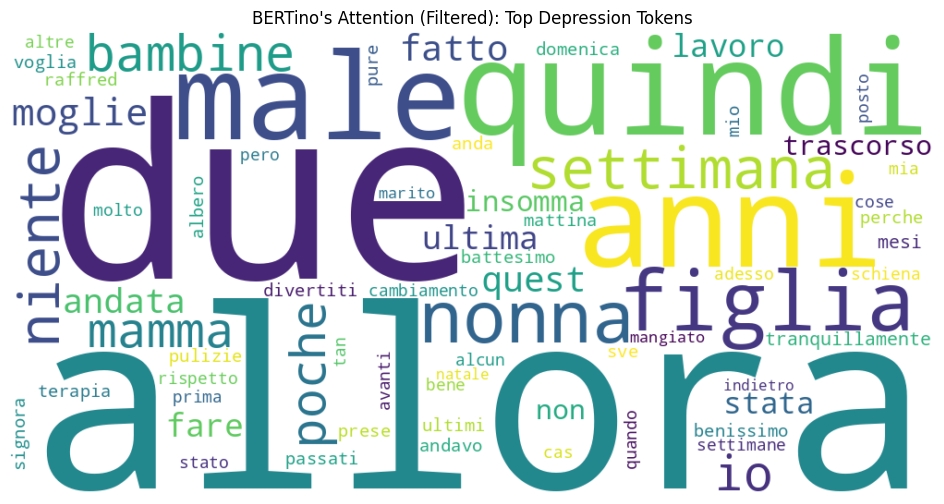

In [36]:
wc = WordCloud(width=1000, height=500, background_color="white").generate_from_frequencies(filtered_tokens)

plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("BERTino's Attention (Filtered): Top Depression Tokens")
plt.show()